# <font color='darkblue'> Part 3 : Smoking Network Classification using Graph Convolutional Networks</font> 

In this part we will work with a Graph Convolutional Network (GCN). 

In the previous part we formulated a task to predict whether individuals in the Generation Scotland Dataset have ever smoked. 

We generated a patient similarity network from CpG sites which are known to be associated with smoking. We will also work with the patient similarity network generated in section 1. 

In this part we postulate that individuals who have previously smoked will share similar epigenetic markers which we can learn from. 
We will now highlight the difference between our two networks to see if we can learn from them

In this part we will be : 
- Working with Deep Graph Library
- Building a GCN 
- Training a GCN
- Comparing the performance of PSN's 
- Comparing the performance of GCN to simple linear regression

## <font color='darkblue'>Import Functions and Packages </font>

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.insert(0 , './../functions.py')

## <font color='darkblue'> Load Data and Network </font>

In [2]:
# Load the data using pickle
with open('./../data/GCN_Data.pkl' , 'rb') as file : 
    loaded_data = pd.read_pickle(file)

## <font color='darkblue'> Working with [Deep Graph Library](https://www.dgl.ai/)</font>

In [3]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch

g = dgl.from_networkx(loaded_data['PSN_EWAS'] , node_attrs=['idx' , 'label']) # Create a DGL graph from the networkx graph
g.ndata['feat'] = torch.Tensor(loaded_data['Feat'].iloc[g.ndata['idx'].numpy()].values) # Add the features to the nodes

In [4]:
# Sanity Check that our graph is preserved
phenotypes = loaded_data['phenotypes'] # Load the phenotypes

node_0 = phenotypes.iloc[g.ndata['idx'].numpy()].iloc[0] # Get the idx of the first node of the dgl graph

node_0_edges = []
for e1 , e2 in loaded_data['PSN_EWAS'].edges(node_0.name) :  # Get the edges of this node in the networkx graph
    node_0_edges.append(e2)
        
# Note : DGL will reorder the nodes if integers present in the node name

sorted(list(phenotypes.iloc[g.ndata['idx'].numpy()].iloc[g.out_edges(0)[1].numpy()].index)) == sorted(node_0_edges) # Check if the edges match between the networkx and dgl graph

True

## <font color='darkblue'>Graph Convolutional Network </font>

Here we will specify the layers of the GCN model using the [GraphConv](https://docs.dgl.ai/en/2.0.x/generated/dgl.nn.pytorch.conv.GraphConv.html) class from DGL.
        
See [Object Oriented Programming](https://www.w3schools.com/python/python_classes.asp) for more information on building classes in python.

See [GraphConv](https://docs.dgl.ai/en/2.0.x/generated/dgl.nn.pytorch.conv.GraphConv.html) for more documentation on the class.


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
    
class GCN(nn.Module):
    def __init__(self, input_dim,  hidden_feats, num_classes):
        
        super().__init__()
        
        self.gcnlayers = nn.ModuleList()
        self.drop = nn.Dropout(0.1)
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        The GraphConv class takes in the following arguments:
            1. input_dim : The number of input features
            2. output_dim : The number of output features
            3. activation : The activation function to be used after the layer (we will stick to the default which is None)

        We will create a list of GraphConv layers with the following dimensions:
            1. input_dim -> hidden_feats[0]
            2. hidden_feats[0] -> hidden_feats[1]
            3. hidden_feats[1] -> num_classes

        Where hidden_feats is a list of the number of hidden features in each layer which we will specify later
        '''
        self.gcnlayers.extend([
            GraphConv(input_dim , hidden_feats[0]),
            GraphConv(hidden_feats[0] , hidden_feats[1]),
            GraphConv(hidden_feats[1] , num_classes)
        ])        

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        
        Here we will define the forward pass of the GCN model. 
        
        The forward pass will consist of the following steps:
            1. Pass the input features through the first GraphConv layer
            2. Apply dropout on the output of the first layer & ReLU activation function hint use F.relu
            3. Pass the output of the first layer through the second GraphConv layer
            4. Apply dropout on the output of the first layer & ReLU activation function hint use F.relu
            5. Pass the output of the second layer through the third GraphConv layer
            6. Return the output of the third layer
        '''
        
        h = self.gcnlayers[0](g , h)
        h = F.relu(self.drop(h))
        h = self.gcnlayers[1](g , h)
        h = F.relu(self.drop(h))
        h = self.gcnlayers[2](g , h)
            
        return h

### <font color='darkblue'> Training & Evaluation </font>

We need to define training and evaluation functions for our GCN model. The code provided follows the outline defined in Chapter 6 of [Hamilton's book](https://www.cs.mcgill.ca/~wlh/grl_book/) for training GNN's. 

The code below is fully operational and provided for practical demonstration. Similar examples of GNN training functions are provided by DGL in their [Blitz Introduction](https://docs.dgl.ai/tutorials/blitz/index.html)

In these functions we implement [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for multi-class classification. We use the [Adam Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) to update the model parameters and we use the [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) function to decay the learning rate

In [6]:
import torch.optim as optim
import torch.nn as nn
import sklearn as sk
import seaborn as sns
from sklearn.metrics import precision_recall_curve , average_precision_score , recall_score ,  PrecisionRecallDisplay
from tqdm.notebook import tqdm

def train(g, h, train_split , val_split , device ,  model , labels , epochs , lr):
    # loss function, optimizer and scheduler
    loss_fcn = nn.CrossEntropyLoss() # [Cross Entropy Loss for multi-class classification](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
    optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=1e-4) # Optimizer to update model parameters [Adam Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8) # Scheduler function to decay the learning rate [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)

    train_loss = []
    val_loss   = []
    train_acc  = []
    val_acc    = []
    
    # training loop
    epoch_progress = tqdm(total=epochs, desc='Loss : ', unit='epoch') # tqdm progress bar for epochs
    for epoch in range(epochs):
        model.train() # Set the model to training mode

        logits  = model(g, h) # Get the logits from the model. Logits are analagous to the node features estimates obtained during the karate club toy example

        loss = loss_fcn(logits[train_split], labels[train_split].float()) # Calculate the loss i.e. how far off the model is from the true labels
        train_loss.append(loss.item())
        
        optimizer.zero_grad() # Zero the gradients before backpropagation
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update the model parameters based on the gradients

        scheduler.step() # Step the scheduler to decay the learning rate
        
        if (epoch % 5) == 0 :
            
            _, predicted = torch.max(logits[train_split], 1) # Get the predicted labels from the model
            _, true = torch.max(labels[train_split] , 1) # Get the true labels
            train_acc.append((predicted == true).float().mean().item()) # Calculate the accuracy of the model on the training set

            valid_loss , valid_acc , *_ = evaluate(val_split, device, g , h, model , labels) # Evaluate the model on the validation set
            val_loss.append(valid_loss.item())
            val_acc.append(valid_acc)
            
            epoch_desc = (
                "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
                    epoch, np.mean(train_loss[-5:]) , np.mean(train_acc[-5:]), np.mean(val_acc[-5:])
                )
            )
            
            epoch_progress.set_description(epoch_desc) # Update the progress bar description
            epoch_progress.update(5) # Update the progress bar by 5 epochs

    # Plot the training and validation loss
    fig1 , ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_loss  , label = 'Train Loss')
    ax1.plot(range(5 , len(train_loss)+1 , 5) , val_loss  , label = 'Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot the training and validation accuracy
    fig2 , ax2 = plt.subplots(figsize=(6,4))
    ax2.plot(train_acc  , label = 'Train Accuracy')
    ax2.plot(val_acc  , label = 'Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_ylim(0,1)
    ax2.legend()
    
    # Close tqdm for epochs
    epoch_progress.close()

    return fig1 , fig2

# Define a function to evaluate the model on the validation and test set 
def evaluate(split, device, g , h, model , labels):
    model.eval() # Set the model to evaluation mode i.e. turn off dropout etc.. 
    loss_fcn = nn.CrossEntropyLoss() # Loss function for multi-class classification [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
    acc = 0
    
    with torch.no_grad() :  # Turn off gradient computation for evaluation
        logits = model(g, h) # Get the logits from the model
        
        loss = loss_fcn(logits[split], labels[split].float()) # Calculate the loss on the validation or test set

        _, predicted = torch.max(logits[split], 1) # Get the predicted labels
        _, true = torch.max(labels[split] , 1) # Get the true labels
        acc = (predicted == true).float().mean().item() # Calculate the accuracy of the model
        
        logits_out = logits[split].cpu().detach().numpy()  # Calculate the loss i.e. how far off the model is from the true labels
        binary_out = (logits_out == logits_out.max(1).reshape(-1,1))*1 # Convert the logits to binary predictions
        
        labels_out = labels[split].cpu().detach().numpy() # Get the true labels
        
        PRC =  average_precision_score(labels_out , binary_out , average="weighted") # Calculate the precision
        SNS = recall_score(labels_out , binary_out , average="weighted") # Calculate the recall
        F1 = 2*((PRC*SNS)/(PRC+SNS)) # Calculate the F1 score
        
    
    return loss , acc , F1 , PRC , SNS

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


GCN(
  (gcnlayers): ModuleList(
    (0): GraphConv(in=23676, out=128, normalization=both, activation=None)
    (1): GraphConv(in=128, out=32, normalization=both, activation=None)
    (2): GraphConv(in=32, out=2, normalization=both, activation=None)
  )
  (drop): Dropout(p=0.1, inplace=False)
)
Graph(num_nodes=1000, num_edges=38796,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int32), 'label': Scheme(shape=(), dtype=torch.int8), 'feat': Scheme(shape=(23676,), dtype=torch.float32)}
      edata_schemes={})


Loss :   0%|          | 0/1000 [00:00<?, ?epoch/s]

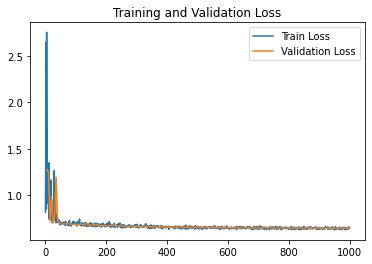

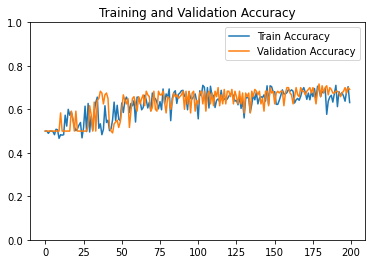

GNN Model | Test Accuracy = 0.6575 | F1 = 0.6305 |


In [7]:
from sklearn.model_selection import train_test_split

device = ('cuda' if torch.cuda.is_available() else 'cpu') # Set the device to GPU if available else CPU

g = g.to(device) # Move the graph to the device

# Get the node labels from the meta data, order by network nodes and reset the index
node_subjects = phenotypes['Smoking'].iloc[g.ndata['idx'].detach().cpu().numpy()].reset_index(drop=True) # Get node target labels from meta data 
node_subjects.name = 'Smoking'

GCN_input_shapes = g.ndata['feat'].shape[1] # Get the input shape of the GCN model

labels = F.one_hot(g.ndata['label'].to(torch.int64)) # Encode the labels as one hot vectors

output_metrics = []
logits = np.array([])
labels_all = np.array([])

train_tmp_index , test_index = train_test_split(                    # Split the data into a temporary training and test set
    node_subjects.index, train_size=0.6, stratify=node_subjects
    )
train_index , val_index = train_test_split(                         # Split the temporary training set into a training and validation set
    train_tmp_index, train_size=0.8, stratify=node_subjects.loc[train_tmp_index]
    )

model = GCN(GCN_input_shapes, hidden_feats=[128 , 32], num_classes=len(node_subjects.unique())).to(device) # Create the GCN model
print(model)
print(g)

loss_plot = train(g, g.ndata['feat'] , train_index , val_index , device ,  model , labels , 1000 , 1e-3) # Train the model
plt.show()

test_output_metrics = evaluate(test_index , device , g , g.ndata['feat'] , model , labels ) # Evaluate the model on the test set

# Print the test accuracy and F1 score
print(
    "GNN Model | Test Accuracy = {:.4f} | F1 = {:.4f} |".format(
     test_output_metrics[1] , test_output_metrics[2] )
)

In [8]:
from sklearn.linear_model import LogisticRegression # Import the logistic regression model from sklearn

y_vals = labels.detach().cpu().numpy() # Get the labels as numpy arrays
input_data = g.ndata['feat'].detach().cpu().numpy() # Get the input features as numpy arrays

glmnet = LogisticRegression(penalty='l1' , solver='saga', max_iter = 1000 ) # Create a logistic regression model with L1 regularization
glmnet.fit(input_data[train_index] , y_vals[train_index][: , 0]) # Fit the logistic regression model
glmnet_acc = glmnet.score(input_data[test_index] , y_vals[test_index][: , 0]) # Get the accuracy of the logistic regression model on the test set
print(f'Baseline Logistic Regression ACC : {glmnet_acc}') # Print the accuracy of the logistic regression model

Baseline Logistic Regression ACC : 0.725


C:\Users\Barry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Our model does not outperform a simple linear regression model. This suggests that the gloabal relationships in the input data are stronger than the local relationships of our network

i.e. The local structure enforced by our network is less informative that learning from all features at once

In the next part, we will exhibit the predictive power of informative local structure by making a more informative network created from more than one modality